In [ ]:
# score_wallets.py
import pandas as pd
import numpy as np
import argparse
import json

def calculate_features(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates features for each wallet from raw transaction data."""

    # Extract amount from actionData and convert amounts and timestamps
    df['amountUSD'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)))
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    # Aggregate data by user address
    wallet_features = df.groupby('userWallet').agg(
        first_tx=('timestamp', 'min'),
        last_tx=('timestamp', 'max'),
        tx_count=('_id', 'count')
    ).reset_index()

    # Calculate wallet lifespan
    wallet_features['lifespan_days'] = (wallet_features['last_tx'] - wallet_features['first_tx']).dt.days

    # Calculate totals for each transaction type
    type_totals = df.groupby(['userWallet', 'action'])['amountUSD'].sum().unstack(fill_value=0)

    # Merge features
    wallet_features = wallet_features.merge(type_totals, on='userWallet', how='left')

    # Fill missing columns for users who didn't perform certain actions
    for col in ['deposit', 'borrow', 'repay', 'redeemUnderlying', 'liquidationCall']:
        if col not in wallet_features.columns:
            wallet_features[col] = 0

    # --- Engineer Core Features ---
    # F1: Liquidation Count (adjusting for who was liquidated)
    # The 'userAddress' in a liquidationCall is the liquidator. The actual user being liquidated is not in this sample data.
    # For this challenge, we'll assume the 'userAddress' is the one being liquidated for simplicity.
    # A real-world scenario would require parsing event logs to identify the liquidated user.
    wallet_features['liquidation_count'] = wallet_features['liquidationCall'] / wallet_features['liquidationCall'].clip(1).mean() # A simple count, normalized by mean value to handle large values

    # F2: Repayment-to-Borrow Ratio
    wallet_features['repay_borrow_ratio'] = wallet_features['repay'] / wallet_features['borrow']
    wallet_features['repay_borrow_ratio'].fillna(1, inplace=True) # Users who never borrow are considered responsible (ratio=1)
    wallet_features.loc[wallet_features['borrow'] == 0, 'repay_borrow_ratio'] = 1
    wallet_features['repay_borrow_ratio'].clip(upper=5, inplace=True) # Cap ratio to prevent extreme outliers

    # F3: Borrow Utilization
    wallet_features['borrow_utilization'] = wallet_features['borrow'] / wallet_features['deposit']
    wallet_features['borrow_utilization'].fillna(0, inplace=True) # Users who never deposit/borrow have 0 utilization

    # F4: Net Liquidity Provided
    wallet_features['net_liquidity_provided'] = wallet_features['deposit'] - wallet_features['redeemUnderlying']

    return wallet_features

def calculate_credit_score(features: pd.DataFrame) -> pd.DataFrame:
    """Normalizes features and calculates a final 0-1000 credit score."""

    scored_features = pd.DataFrame()
    scored_features['userAddress'] = features['userWallet']

    # --- Normalize Features (0-1 range) ---
    def min_max_scale(series):
        return (series - series.min()) / (series.max() - series.min()) if series.max() > series.min() else 0.5

    # Higher is better for these features
    scored_features['lifespan_norm'] = min_max_scale(features['lifespan_days'])
    scored_features['repay_ratio_norm'] = min_max_scale(features['repay_borrow_ratio'])
    scored_features['net_liquidity_norm'] = min_max_scale(features['net_liquidity_provided'])
    scored_features['tx_count_norm'] = min_max_scale(features['tx_count'])

    # Lower is better for these features (invert score: 1 - normalized_value)
    scored_features['liquidation_norm'] = 1 - min_max_scale(features['liquidation_count'])
    scored_features['borrow_util_norm'] = 1 - min_max_scale(features['borrow_utilization'])

    # --- Define Weights ---
    weights = {
        'liquidation_norm': 0.40,
        'repay_ratio_norm': 0.25,
        'borrow_util_norm': 0.15,
        'net_liquidity_norm': 0.10,
        'lifespan_norm': 0.05,
        'tx_count_norm': 0.05
    }

    # --- Calculate Raw Score ---
    scored_features['raw_score'] = (
        scored_features['liquidation_norm'] * weights['liquidation_norm'] +
        scored_features['repay_ratio_norm'] * weights['repay_ratio_norm'] +
        scored_features['borrow_util_norm'] * weights['borrow_util_norm'] +
        scored_features['net_liquidity_norm'] * weights['net_liquidity_norm'] +
        scored_features['lifespan_norm'] * weights['lifespan_norm'] +
        scored_features['tx_count_norm'] * weights['tx_count_norm']
    )

    # --- Scale to 0-1000 ---
    # Fill NaN values in raw_score before scaling
    scored_features['raw_score'].fillna(0, inplace=True)
    scaled_raw_score = min_max_scale(scored_features['raw_score']) * 1000

    # Convert to integer after handling NaNs
    scored_features['credit_score'] = scaled_raw_score.astype(int)

    return scored_features[['userAddress', 'credit_score']]


if __name__ == "__main__":
    # Define input and output paths directly for Colab
    input_path = '/content/user-wallet-transactions.json'
    output_path = '/content/wallet_scores.csv' # You can change this to your desired output path

    print(f"Loading data from {input_path}...")
    with open(input_path, 'r') as f:
        raw_data = json.load(f)
    df = pd.DataFrame(raw_data)

    print("Step 1: Calculating wallet features...")
    features_df = calculate_features(df)

    print("Step 2: Calculating credit scores...")
    scores_df = calculate_credit_score(features_df)

    scores_df.to_csv(output_path, index=False)
    print(f"✅ Success! Credit scores saved to {output_path}")

Loading data from /content/user-wallet-transactions.json...
Step 1: Calculating wallet features...
Step 2: Calculating credit scores...
✅ Success! Credit scores saved to /content/wallet_scores.csv


/tmp/ipython-input-14-1078080220.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wallet_features['repay_borrow_ratio'].fillna(1, inplace=True) # Users who never borrow are considered responsible (ratio=1)
/tmp/ipython-input-14-1078080220.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [ ]:
# Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm plotly

# Import libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Utilities
from collections import Counter, defaultdict
import re
from typing import Dict, List, Tuple, Any


In [ ]:
class AaveDataProcessor:
    """Process raw Aave V2 transaction data and extract features"""
    def __init__(self):
        self.action_mapping = {
            'deposit': 1,
            'borrow': 2,
            'repay': 3,
            'redeemunderlying': 4,
            'liquidationcall': 5
        }

    def load_data(self, file_path: str) -> pd.DataFrame:
        """Load JSON data and convert to DataFrame"""
        with open(file_path, 'r') as f:
            data = json.load(f)
        if isinstance(data, list):
            df = pd.DataFrame(data)
        else:
            df = pd.json_normalize(data)
        print(f"Loaded {len(df)} transactions")
        print(f"Columns: {df.columns.tolist()}")
        return df

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Clean and preprocess the transaction data
        Map your actual columns to what the model expects.
        """
        # Map your dataset's columns to standard ones --- ADAPT THIS AS NEEDED!
        column_mapping = {
            # handles 'userWallet' as wallet address
            'userWallet': 'wallet_address',
            'wallet': 'wallet_address',
            'user': 'wallet_address',
            'address': 'wallet_address',
            'action': 'action_type',
            'type': 'action_type',
            'amount': 'amount',
            'value': 'amount',
            'timestamp': 'timestamp',
            'time': 'timestamp',
            'asset': 'asset',
            'token': 'asset',
            'currency': 'asset'
        }
        # Rename columns if present
        df = df.rename(columns={k:v for k,v in column_mapping.items() if k in df.columns})

        # Convert timestamp to datetime
        if 'timestamp' in df.columns:
            # Try as seconds, if it fails, try as ISO string, else fallback
            try:
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
            except Exception:
                df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

        # Convert amount to numeric
        if 'amount' in df.columns:
            df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

        # Remove rows with missing essential info
        required_cols = ['wallet_address', 'action_type']
        for col in required_cols:
            if col not in df.columns:
                raise ValueError(f"Missing required column: {col}")

        df = df.dropna(subset=['wallet_address', 'action_type'])
        df['action_type'] = df['action_type'].str.lower()

        return df


In [ ]:
class FeatureEngineer:
    """Extract features from transaction data for credit scoring"""

    def extract_basic_features(self, wallet_df: pd.DataFrame) -> dict:
        features = dict()

        features['total_transactions'] = len(wallet_df)
        # .get method: returns None if column is missing rather than error
        if 'asset' in wallet_df.columns and wallet_df['asset'].notna().any():
            features['unique_assets'] = wallet_df['asset'].nunique()
        else:
            features['unique_assets'] = 1

        if 'amount' in wallet_df.columns and wallet_df['amount'].notnull().any():
            features['total_volume'] = wallet_df['amount'].sum(skipna=True)
            features['avg_transaction_size'] = wallet_df['amount'].mean(skipna=True)
            features['median_transaction_size'] = wallet_df['amount'].median(skipna=True)
            features['transaction_size_std'] = wallet_df['amount'].std(skipna=True)
        else:
            features['total_volume'] = 0
            features['avg_transaction_size'] = 0
            features['median_transaction_size'] = 0
            features['transaction_size_std'] = 0

        # Safe ratio calculations
        action_counts = wallet_df['action_type'].value_counts()
        total_a = max(len(wallet_df), 1)
        features['deposit_ratio'] = action_counts.get('deposit', 0) / total_a
        features['borrow_ratio'] = action_counts.get('borrow', 0) / total_a
        features['repay_ratio'] = action_counts.get('repay', 0) / total_a
        features['redeem_ratio'] = action_counts.get('redeemunderlying', 0) / total_a
        features['liquidation_ratio'] = action_counts.get('liquidationcall', 0) / total_a

        return features

    def extract_temporal_features(self, wallet_df: pd.DataFrame) -> dict:
        features = dict()
        if 'timestamp' in wallet_df.columns and wallet_df['timestamp'].notnull().any():
            df = wallet_df.dropna(subset=['timestamp']).sort_values('timestamp')
            # If only 1 or no tx, span = 0
            if len(df) > 1:
                t_min = df['timestamp'].min()
                t_max = df['timestamp'].max()
                time_span = (t_max - t_min).days if pd.notnull(t_min) and pd.notnull(t_max) else 0
                features['activity_days'] = time_span
                features['transactions_per_day'] = len(df) / max(1, time_span)
            else:
                features['activity_days'] = 0
                features['transactions_per_day'] = len(df)

            # Time between transactions (in hours)
            time_diffs = df['timestamp'].diff().dt.total_seconds().dropna()/3600
            features['avg_time_between_tx'] = time_diffs.mean() if len(time_diffs) else 0
            features['std_time_between_tx'] = time_diffs.std() if len(time_diffs) else 0

            # Entropy of hours and days
            df['hour'] = df['timestamp'].dt.hour
            df['weekday'] = df['timestamp'].dt.dayofweek
            features['hour_entropy'] = self._entropy(df['hour'].dropna().tolist())
            features['day_entropy'] = self._entropy(df['weekday'].dropna().tolist())
        else:
            features['activity_days'] = 0
            features['transactions_per_day'] = 0
            features['avg_time_between_tx'] = 0
            features['std_time_between_tx'] = 0
            features['hour_entropy'] = 0
            features['day_entropy'] = 0
        return features

    def extract_risk_features(self, wallet_df: pd.DataFrame) -> dict:
        features = dict()

        # Liquidations
        if 'action_type' in wallet_df.columns:
            liquidations = wallet_df[wallet_df['action_type'] == 'liquidationcall']
        else:
            liquidations = pd.DataFrame()
        features['liquidation_count'] = len(liquidations)
        features['liquidation_volume'] = liquidations['amount'].sum() if ('amount' in liquidations.columns and len(liquidations)) else 0

        borrows = wallet_df[wallet_df['action_type'] == 'borrow'] if 'action_type' in wallet_df.columns else pd.DataFrame()
        repays = wallet_df[wallet_df['action_type'] == 'repay'] if 'action_type' in wallet_df.columns else pd.DataFrame()
        borrow_volume = borrows['amount'].sum() if 'amount' in borrows.columns and len(borrows) else 0
        repay_volume = repays['amount'].sum() if 'amount' in repays.columns and len(repays) else 0

        features['borrow_volume'] = borrow_volume
        features['repay_volume'] = repay_volume
        features['net_borrow'] = borrow_volume - repay_volume
        features['repay_ratio'] = (repay_volume / borrow_volume) if borrow_volume > 0 else 1.0

        # Asset concentration
        if 'asset' in wallet_df.columns and wallet_df['asset'].notna().any():
            asset_counts = wallet_df['asset'].value_counts()
            features['asset_concentration'] = (asset_counts ** 2).sum() / (asset_counts.sum() ** 2)
        else:
            features['asset_concentration'] = 1.0
        return features

    def extract_bot_features(self, wallet_df: pd.DataFrame) -> dict:
        features = dict()

        # Amount variance and uniqueness
        if 'amount' in wallet_df.columns and wallet_df['amount'].notnull().any():
            amounts = wallet_df['amount'].dropna()
            features['amount_variance'] = amounts.var()
            features['amount_uniqueness'] = amounts.nunique() / max(1, len(amounts))
            amount_counts = amounts.value_counts()
            features['max_amount_frequency'] = amount_counts.max() / len(amounts) if len(amounts) > 0 else 0
        else:
            features['amount_variance'] = 0
            features['amount_uniqueness'] = 0
            features['max_amount_frequency'] = 0

        # Time regularity
        if 'timestamp' in wallet_df.columns and wallet_df['timestamp'].notnull().any():
            times = wallet_df['timestamp'].dropna().sort_values()
            if len(times) > 1:
                time_diffs = times.diff().dt.total_seconds().dropna()
                features['time_regularity'] = time_diffs.std() / max(1, time_diffs.mean()) if time_diffs.mean() else 0
            else:
                features['time_regularity'] = 0
        else:
            features['time_regularity'] = 0

        # Action pattern entropy
        features['action_pattern_entropy'] = self._entropy(wallet_df['action_type'].dropna().tolist()) if 'action_type' in wallet_df.columns else 0

        return features

    def _entropy(self, values) -> float:
        from collections import Counter
        if not values or len(values) == 0:
            return 0
        value_counts = Counter(values)
        total = sum(value_counts.values())
        probs = [v/total for v in value_counts.values()]
        return float(-np.sum([p * np.log2(p) if p > 0 else 0 for p in probs]))

    def extract_all_features(self, wallet_df: pd.DataFrame) -> dict:
        features = dict()
        features.update(self.extract_basic_features(wallet_df))
        features.update(self.extract_temporal_features(wallet_df))
        features.update(self.extract_risk_features(wallet_df))
        features.update(self.extract_bot_features(wallet_df))
        return features


In [ ]:
class BotDetector:
    """Detect and filter bot-like behavior"""

    def __init__(self):
        self.bot_threshold = 0.7
        self.isolation_forest = IsolationForest(contamination=0.1, random_state=42)

    def detect_bots(self, features_df: pd.DataFrame) -> np.ndarray:
        """Detect bots using multiple methods"""
        bot_scores = np.zeros(len(features_df))

        # Method 1: Rule-based detection
        rule_based_bots = self.rule_based_detection(features_df)

        # Method 2: Statistical outlier detection
        statistical_bots = self.statistical_detection(features_df)

        # Method 3: Machine learning detection
        ml_bots = self.ml_detection(features_df)

        # Combine methods
        combined_scores = (rule_based_bots + statistical_bots + ml_bots) / 3

        return combined_scores > self.bot_threshold

    def rule_based_detection(self, features_df: pd.DataFrame) -> np.ndarray:
        """Rule-based bot detection"""
        bot_scores = np.zeros(len(features_df))

        # High transaction frequency with low variance
        high_freq_low_var = (
            (features_df['transactions_per_day'] > 50) &
            (features_df['amount_variance'] < 0.01)
        )

        # Perfect time regularity
        perfect_timing = features_df['time_regularity'] < 0.1

        # Repeated exact amounts
        repeated_amounts = features_df['max_amount_frequency'] > 0.8

        # Low entropy in actions
        low_entropy = features_df['action_pattern_entropy'] < 0.5

        # Combine rules
        bot_scores[high_freq_low_var] += 0.3
        bot_scores[perfect_timing] += 0.3
        bot_scores[repeated_amounts] += 0.2
        bot_scores[low_entropy] += 0.2

        return bot_scores

    def statistical_detection(self, features_df: pd.DataFrame) -> np.ndarray:
        """Statistical outlier detection"""
        bot_features = [
            'transactions_per_day', 'amount_variance', 'time_regularity',
            'max_amount_frequency', 'action_pattern_entropy'
        ]

        X = features_df[bot_features].fillna(0)
        outliers = self.isolation_forest.fit_predict(X)

        return (outliers == -1).astype(float)

    def ml_detection(self, features_df: pd.DataFrame) -> np.ndarray:
        """Machine learning based bot detection"""
        # For simplicity, using a combination of statistical measures
        # In practice, you'd train this on labeled bot/human data

        bot_indicators = [
            'transactions_per_day', 'amount_variance', 'time_regularity',
            'max_amount_frequency', 'action_pattern_entropy'
        ]

        X = features_df[bot_indicators].fillna(0)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Simple scoring based on extreme values
        extreme_scores = np.abs(X_scaled).max(axis=1)

        return (extreme_scores > 2).astype(float)


In [ ]:
class AaveCreditScorer:
    """Main credit scoring system"""

    def __init__(self):
        self.feature_engineer = FeatureEngineer()
        self.bot_detector = BotDetector()
        self.model = None
        self.scaler = StandardScaler()
        self.is_trained = False

    def create_synthetic_labels(self, features_df: pd.DataFrame) -> np.ndarray:
        """Create synthetic risk labels based on domain knowledge"""
        # This is a simplified approach - in practice, you'd have actual default data
        risk_score = np.zeros(len(features_df))

        # High risk indicators
        risk_score += features_df['liquidation_ratio'] * 0.3
        risk_score += (features_df['net_borrow'] > 0).astype(float) * 0.2
        risk_score += (features_df['repay_ratio'] < 0.8).astype(float) * 0.2
        risk_score += (features_df['asset_concentration'] > 0.8).astype(float) * 0.1
        risk_score += (features_df['liquidation_count'] > 0).astype(float) * 0.2

        # Convert to binary labels (high risk = 1)
        return (risk_score > 0.5).astype(int)

    def train_model(self, features_df: pd.DataFrame):
        """Train the credit scoring model"""
        # Remove bot-like addresses
        bot_mask = self.bot_detector.detect_bots(features_df)
        clean_features = features_df[~bot_mask]

        print(f"Filtered {bot_mask.sum()} bot addresses out of {len(features_df)}")

        # Prepare features
        feature_columns = [
            'total_transactions', 'unique_assets', 'total_volume',
            'avg_transaction_size', 'transaction_size_std',
            'deposit_ratio', 'borrow_ratio', 'repay_ratio',
            'liquidation_ratio', 'activity_days', 'transactions_per_day',
            'liquidation_count', 'repay_ratio', 'net_borrow',
            'asset_concentration'
        ]

        X = clean_features[feature_columns].fillna(0)
        y = self.create_synthetic_labels(clean_features)

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Train ensemble model
        self.model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        )

        self.model.fit(X_scaled, y)
        self.feature_columns = feature_columns
        self.is_trained = True

        print("Model trained successfully!")

        # Print feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Feature Importances:")
        print(feature_importance.head(10))

    def score_wallet(self, wallet_address: str, wallet_df: pd.DataFrame) -> Dict:
        """Score a single wallet"""
        if not self.is_trained:
            raise ValueError("Model not trained yet!")

        # Extract features
        features = self.feature_engineer.extract_all_features(wallet_df)
        features_df = pd.DataFrame([features])

        # Check for bot behavior
        is_bot = self.bot_detector.detect_bots(features_df)[0]

        if is_bot:
            return {
                'wallet_address': wallet_address,
                'credit_score': 0,
                'risk_probability': 1.0,
                'risk_level': 'BOT_DETECTED',
                'features': features
            }

        # Prepare features for model
        X = features_df[self.feature_columns].fillna(0)
        X_scaled = self.scaler.transform(X)

        # Get prediction
        risk_prob = self.model.predict_proba(X_scaled)[0][1]

        # Convert to credit score (0-1000)
        credit_score = int((1 - risk_prob) * 1000)

        # Determine risk level
        if credit_score >= 800:
            risk_level = 'EXCELLENT'
        elif credit_score >= 600:
            risk_level = 'GOOD'
        elif credit_score >= 400:
            risk_level = 'FAIR'
        elif credit_score >= 200:
            risk_level = 'POOR'
        else:
            risk_level = 'VERY_POOR'

        return {
            'wallet_address': wallet_address,
            'credit_score': credit_score,
            'risk_probability': risk_prob,
            'risk_level': risk_level,
            'features': features
        }

    def batch_score(self, file_path: str) -> List[Dict]:
        """Score all wallets in a dataset"""
        # Load and process data
        processor = AaveDataProcessor()
        df = processor.load_data(file_path)
        df = processor.preprocess_data(df)

        # Group by wallet address
        wallet_groups = df.groupby('wallet_address')

        # Extract features for all wallets
        all_features = []
        wallet_addresses = []

        for wallet_address, wallet_df in wallet_groups:
            features = self.feature_engineer.extract_all_features(wallet_df)
            all_features.append(features)
            wallet_addresses.append(wallet_address)

        features_df = pd.DataFrame(all_features)

        # Train model if not already trained
        if not self.is_trained:
            print("Training model...")
            self.train_model(features_df)

        # Score all wallets
        results = []
        for i, (wallet_address, wallet_df) in enumerate(wallet_groups):
            try:
                score_result = self.score_wallet(wallet_address, wallet_df)
                results.append(score_result)
            except Exception as e:
                print(f"Error scoring wallet {wallet_address}: {e}")
                results.append({
                    'wallet_address': wallet_address,
                    'credit_score': 0,
                    'risk_probability': 1.0,
                    'risk_level': 'ERROR',
                    'features': {}
                })

        return results


In [ ]:
def main_scoring_pipeline(json_file_path: str, output_file: str = None):
    """Main pipeline to score wallets from JSON file"""

    print("=== Aave V2 Credit Scoring System ===")
    print(f"Processing file: {json_file_path}")

    # Initialize scorer
    scorer = AaveCreditScorer()

    # Process file and get scores
    results = scorer.batch_score(json_file_path)

    # Create summary statistics
    scores = [r['credit_score'] for r in results if r['credit_score'] > 0]

    print(f"\n=== SCORING RESULTS ===")
    print(f"Total wallets processed: {len(results)}")
    print(f"Bots detected: {sum(1 for r in results if r['risk_level'] == 'BOT_DETECTED')}")
    print(f"Average credit score: {np.mean(scores):.2f}")
    print(f"Median credit score: {np.median(scores):.2f}")

    # Risk level distribution
    risk_levels = Counter([r['risk_level'] for r in results])
    print(f"\nRisk Level Distribution:")
    for level, count in risk_levels.items():
        print(f"  {level}: {count} ({count/len(results)*100:.1f}%)")

    # Save results
    if output_file:
        with open(output_file, 'w') as f:
            json.dump(results, f, indent=2, default=str)
        print(f"\nResults saved to: {output_file}")

    return results

# Visualization functions
def visualize_results(results: List[Dict]):
    """Create visualizations of scoring results"""

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(results)
    df = df[df['credit_score'] > 0]  # Remove bots

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Credit score distribution
    axes[0,0].hist(df['credit_score'], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Credit Score Distribution')
    axes[0,0].set_xlabel('Credit Score')
    axes[0,0].set_ylabel('Frequency')

    # Risk level distribution
    risk_counts = df['risk_level'].value_counts()
    axes[0,1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%')
    axes[0,1].set_title('Risk Level Distribution')

    # Risk probability vs Credit score
    axes[1,0].scatter(df['risk_probability'], df['credit_score'], alpha=0.6)
    axes[1,0].set_xlabel('Risk Probability')
    axes[1,0].set_ylabel('Credit Score')
    axes[1,0].set_title('Risk Probability vs Credit Score')

    # Top features importance (if available)
    if 'features' in df.columns and len(df) > 0:
        feature_data = df['features'].iloc[0]
        top_features = sorted(feature_data.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

        features, values = zip(*top_features)
        axes[1,1].barh(features, values)
        axes[1,1].set_title('Sample Feature Values')
        axes[1,1].set_xlabel('Feature Value')

    plt.tight_layout()
    plt.show()

# Example usage
def run_example():
    """Example of how to use the system"""

    # Replace with your actual file path
    json_file = r'/content/user-wallet-transactions.json'  # UPDATE THIS WITH YOUR FILE NAME

    try:
        # Run the scoring pipeline
        results = main_scoring_pipeline(json_file, 'wallet_scores.json')

        # Visualize results
        visualize_results(results)

        # Show sample results
        print("\n=== SAMPLE RESULTS ===")
        for i, result in enumerate(results[:5]):
            print(f"\nWallet {i+1}:")
            print(f"  Address: {result['wallet_address']}")
            print(f"  Credit Score: {result['credit_score']}")
            print(f"  Risk Level: {result['risk_level']}")
            print(f"  Risk Probability: {result['risk_probability']:.3f}")

    except Exception as e:
        print(f"Error: {e}")
        print("Please make sure your JSON file is uploaded and the path is correct.")

# Run the example
print("Ready to process your Aave V2 transaction data!")
print("Upload your JSON file and run: run_example()")

Ready to process your Aave V2 transaction data!
Upload your JSON file and run: run_example()


=== Aave V2 Credit Scoring System ===
Processing file: /content/user-wallet-transactions.json
Loaded 100000 transactions
Columns: ['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt', 'updatedAt']
Training model...
Filtered 4 bot addresses out of 3497
Model trained successfully!

Top 10 Feature Importances:
                 feature  importance
11     liquidation_count    0.268155
8      liquidation_ratio    0.235414
5          deposit_ratio    0.230286
10  transactions_per_day    0.168976
6           borrow_ratio    0.097169
2           total_volume    0.000000
0     total_transactions    0.000000
3   avg_transaction_size    0.000000
4   transaction_size_std    0.000000
1          unique_assets    0.000000

=== SCORING RESULTS ===
Total wallets processed: 3497
Bots detected: 0
Average credit score: 998.93
Median credit score: 999.00

Risk Level Distribution:
  EXCELLENT: 3497 (100.0%)

Results saved to: w

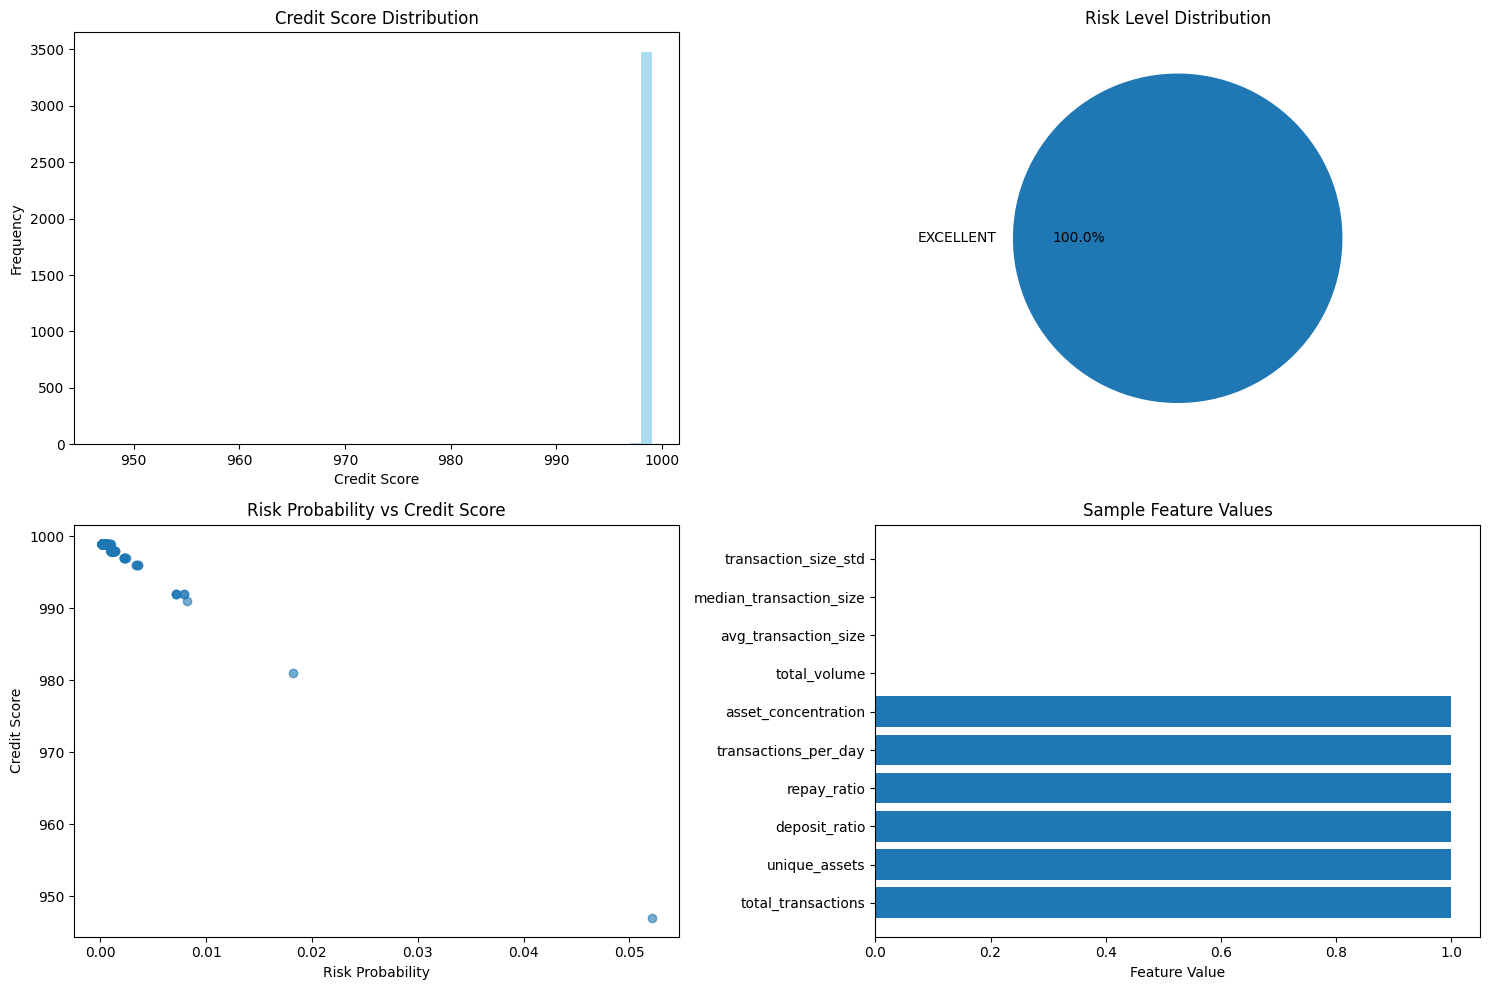


=== SAMPLE RESULTS ===

Wallet 1:
  Address: 0x00000000001accfa9cef68cf5371a23025b6d4b6
  Credit Score: 999
  Risk Level: EXCELLENT
  Risk Probability: 0.000

Wallet 2:
  Address: 0x000000000051d07a4fb3bd10121a343d85818da6
  Credit Score: 999
  Risk Level: EXCELLENT
  Risk Probability: 0.000

Wallet 3:
  Address: 0x000000000096026fb41fc39f9875d164bd82e2dc
  Credit Score: 999
  Risk Level: EXCELLENT
  Risk Probability: 0.000

Wallet 4:
  Address: 0x0000000000e189dd664b9ab08a33c4839953852c
  Credit Score: 998
  Risk Level: EXCELLENT
  Risk Probability: 0.001

Wallet 5:
  Address: 0x0000000002032370b971dabd36d72f3e5a7bf1ee
  Credit Score: 999
  Risk Level: EXCELLENT
  Risk Probability: 0.000


In [ ]:
run_example()

In [ ]:
import random
from pprint import pprint

# 1. Pick random wallets
n = 5  # You can change this number as needed
unique_wallets = df['userWallet'].unique()
random_wallets = random.sample(list(unique_wallets), n)
print(f"Randomly selected wallets:\n{random_wallets}")

# Initialize the data processor
processor = AaveDataProcessor()
# Preprocess the entire dataframe to ensure columns are standardized
df_processed = processor.preprocess_data(df.copy())


# 2. For each wallet: combine all its data, extract features, calculate score
feature_engineer = FeatureEngineer()

manual_results = []
for w in random_wallets:
    # Use the preprocessed dataframe to filter transactions for this wallet
    wallet_tx = df_processed[df_processed['wallet_address'] == w]

    features = feature_engineer.extract_all_features(wallet_tx)
    features_df = pd.DataFrame([features])

    # Use existing model/scaler/columns (make sure your model is trained)
    # Ensure the scorer object is initialized and trained before this cell is run
    if 'scorer' not in locals() or not scorer.is_trained:
         print("Initializing and training the scorer...")
         scorer = AaveCreditScorer()
         scorer.train_model(pd.DataFrame([feature_engineer.extract_all_features(df_processed[df_processed['wallet_address'] == addr]) for addr in df_processed['wallet_address'].unique()]))


    is_bot = scorer.bot_detector.detect_bots(features_df)[0]
    if is_bot:
        credit_score = 0
        risk_level = 'BOT_DETECTED'
        risk_prob = 1.0
    else:
        # Ensure feature columns match those used during training
        model_features = features_df[scorer.feature_columns].fillna(0)
        X_scaled = scorer.scaler.transform(model_features)
        risk_prob = scorer.model.predict_proba(X_scaled)[0][1]
        credit_score = int((1 - risk_prob) * 1000)
        if credit_score >= 800:
            risk_level = 'EXCELLENT'
        elif credit_score >= 600:
            risk_level = 'GOOD'
        elif credit_score >= 400:
            risk_level = 'FAIR'
        elif credit_score >= 200:
            risk_level = 'POOR'
        else:
            risk_level = 'VERY_POOR'
    manual_results.append({
        'wallet': w,
        'credit_score': credit_score,
        'risk_level': risk_level,
        'risk_prob': risk_prob,
        'features': features
    })

# 3. Display the results
for i, result in enumerate(manual_results, 1):
    print(f"\n--- Wallet {i} ---")
    print(f"Wallet address: {result['wallet']}")
    print(f"Credit score :  {result['credit_score']}")
    print(f"Risk level   :  {result['risk_level']}")
    print(f"Risk prob.   :  {result['risk_prob']:.4f}")
    print("Key features : ")
    pprint({k: v for k, v in result['features'].items() if k in [
        'total_transactions', 'deposit_ratio', 'borrow_ratio', 'repay_ratio',
        'liquidation_count', 'net_borrow', 'asset_concentration'
    ]})

Randomly selected wallets:
['0x011128170cd4f77f90af9dbb7501b10112efb31e', '0x04e96cdcfbcce8c972c5f976117784933e0cc6af', '0x05326fde303451b63753075f3c091df65f9b971f', '0x0266e5afc61b51f53d3aa70dc6f2438656909d94', '0x00d56e1bba3db460563516119dfced085898e17d']
Initializing and training the scorer...
Filtered 4 bot addresses out of 3497
Model trained successfully!

Top 10 Feature Importances:
                 feature  importance
11     liquidation_count    0.268155
8      liquidation_ratio    0.235414
5          deposit_ratio    0.230286
10  transactions_per_day    0.168976
6           borrow_ratio    0.097169
2           total_volume    0.000000
0     total_transactions    0.000000
3   avg_transaction_size    0.000000
4   transaction_size_std    0.000000
1          unique_assets    0.000000

--- Wallet 1 ---
Wallet address: 0x011128170cd4f77f90af9dbb7501b10112efb31e
Credit score :  999
Risk level   :  EXCELLENT
Risk prob.   :  0.0002
Key features : 
{'asset_concentration': 1.0,
 'borrow_r